<a href="https://colab.research.google.com/github/Alejo10cortes/parcial_ia/blob/main/parcial_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Ejecutar esta celda al inicio del notebook (Colab)
!pip install -q pandas numpy scikit-learn matplotlib seaborn nltk gensim joblib pyldavis wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.3 MB/s eta 0:00:00


In [3]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import gensim
from gensim import corpora


# Descargas NLTK (ejecutar la primera vez)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Cargar data
df = pd.read_csv('spam.csv', encoding='latin-1')
# Vista previa
print(df.shape)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


etiqueta
ham     4825
spam     747
Name: count, dtype: int64


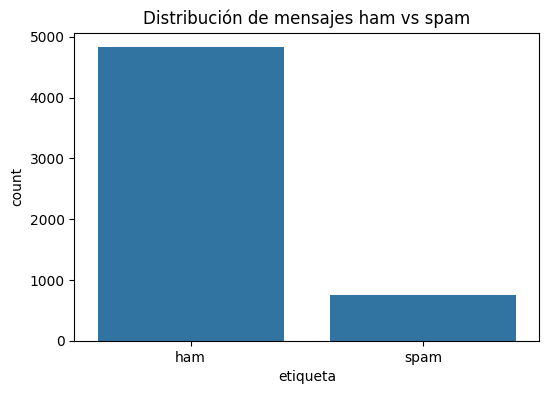

In [6]:
# Renombrar columnas y eliminar innecesarias
if 'v1' in df.columns and 'v2' in df.columns:
    df = df.rename(columns={'v1': 'etiqueta', 'v2': 'texto'})
    for c in df.columns:
        if c not in ['etiqueta', 'texto']:
            df = df.drop(columns=c)

# Normalizar etiquetas
df['etiqueta'] = df['etiqueta'].str.lower().str.strip()

# Conteo de clases
print(df['etiqueta'].value_counts())

# Visualización
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='etiqueta')
plt.title('Distribución de mensajes ham vs spam')
plt.show()


**Análisis:**
- El dataset está desbalanceado: la mayoría de los mensajes son `ham`.
- La exactitud (accuracy) no es confiable, ya que un modelo podría predecir todo como `ham` y aun así tener alta precisión.
- Métricas más relevantes: `precision`, `recall`, `f1-score`.

In [10]:
# Librerías necesarias para el preprocesamiento
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Descargar recursos de NLTK (incluyendo el nuevo 'punkt_tab')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Definir stopwords y lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Función de preprocesamiento
def preprocess_text(text):
    text = str(text).lower()  # Convertir a minúsculas
    text = re.sub(r'[^a-z\s]', ' ', text)  # Eliminar números y signos
    tokens = word_tokenize(text)  # Tokenizar
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]  # Eliminar stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # Lematizar
    return ' '.join(tokens)

# Aplicar la función a la columna 'texto'
df['texto_limpio'] = df['texto'].apply(preprocess_text)

# Ver las primeras filas
df[['texto', 'texto_limpio']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,texto,texto_limpio
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [11]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X = vectorizer.fit_transform(df['texto_limpio'])
y = df['etiqueta'].map({'ham':0,'spam':1})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (4457, 8795) Test: (1115, 8795)


In [12]:
# Modelo 1: Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


print('--- MultinomialNB ---')
print(classification_report(y_test, y_pred_nb, target_names=['ham','spam']))
print(confusion_matrix(y_test, y_pred_nb))


# Modelo 2: Regresión Logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


print('\n--- LogisticRegression ---')
print(classification_report(y_test, y_pred_lr, target_names=['ham','spam']))
print(confusion_matrix(y_test, y_pred_lr))

--- MultinomialNB ---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

[[966   0]
 [ 37 112]]

--- LogisticRegression ---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.72      0.83       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

[[965   1]
 [ 42 107]]


**Negocio:**
- Falso Positivo (ham → spam): usuario pierde mensajes válidos.
- Falso Negativo (spam → ham): usuario recibe spam.


**Peor error:** Falsos Positivos.
**Métrica clave:** `precision` sobre clase spam.
**Modelo recomendado:** El que logre mayor precision para `spam`.

In [14]:
# --- PUNTO 7: ANÁLISIS DE TÓPICOS CON LDA ---
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize

# Filtrar solo los mensajes de spam
spam_df = df[df['etiqueta'] == 'spam']

# Tokenizar los textos limpios
texts = [word_tokenize(text) for text in spam_df['texto_limpio']]

# Crear diccionario y corpus para LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Crear el modelo LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, random_state=42, passes=10)

# Mostrar los tópicos encontrados
for idx, topic in lda_model.print_topics(num_topics=4, num_words=8):
    print(f'Tópico {idx}: {topic}\n')


Tópico 0: 0.046*"call" + 0.020*"prize" + 0.019*"claim" + 0.014*"reply" + 0.014*"new" + 0.013*"mobile" + 0.012*"service" + 0.011*"free"

Tópico 1: 0.031*"free" + 0.022*"txt" + 0.019*"call" + 0.019*"ur" + 0.014*"mobile" + 0.013*"stop" + 0.013*"www" + 0.013*"get"

Tópico 2: 0.028*"call" + 0.017*"box" + 0.014*"cash" + 0.014*"ppm" + 0.013*"urgent" + 0.013*"holiday" + 0.011*"txt" + 0.011*"text"

Tópico 3: 0.030*"call" + 0.019*"stop" + 0.015*"text" + 0.014*"min" + 0.011*"free" + 0.011*"send" + 0.010*"service" + 0.010*"per"



In [16]:
# --- PUNTO 9: GUARDAR EL MODELO Y EL VECTORIZADOR ---
import joblib  # <--- Importar joblib

# Guardar el modelo de Regresión Logística y el vectorizador TF-IDF
joblib.dump(lr, 'logistic_spam_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

print("✅ Modelos guardados exitosamente en el entorno de Colab.")


✅ Modelos guardados exitosamente en el entorno de Colab.
